# Analyser les relations bivari√©es entre s√©ries financi√®res


1. **Mesurer et visualiser la corr√©lation** (matrice + heatmap)
2. **Corr√©lations robustes** (Spearman, Kendall)
3. **R√©gression simple CAPM (express)**
4. **Tableau de contingence** & **test d'ind√©pendance**
5. **Comparer deux groupes** (test t de Welch)
6. **Comparer plusieurs groupes** (ANOVA + Kruskal)
7. **D√©fi & solution**


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy import stats


## Param√®tres & t√©l√©chargement des donn√©es

In [2]:
# --- D√©finition de l'univers d'investissement ---
# Chaque ticker correspond √† une action sp√©cifique.
# Secteur Tech: META (Meta Platforms), AAPL (Apple), MSFT (Microsoft)
# Secteur Financier: JPM (JPMorgan Chase), BAC (Bank of America), C (Citigroup)
# Secteur √ânergie: XOM (Exxon Mobil), CVX (Chevron)

UNIVERSE = ["META", "AAPL", "MSFT", "JPM", "BAC", "C", "XOM", "CVX"]
MARKET_TICKER = "^GSPC"
START_DATE = "2020-01-01"
END_DATE = None

data = yf.download(UNIVERSE + [MARKET_TICKER], start=START_DATE, end=END_DATE, progress=False, auto_adjust=False)

if isinstance(data.columns, pd.MultiIndex):
    prices = data["Adj Close"].copy()
else:
    prices = data[["Adj Close"]].copy()

prices = prices.dropna(how="all")
market_prices = prices[MARKET_TICKER].dropna()
asset_prices = prices.drop(columns=[MARKET_TICKER], errors="ignore").dropna(how="all")

asset_prices.head()


Ticker           AAPL        BAC          C        CVX         JPM  \
Date                                                                 
2020-01-02  72.538521  30.920330  65.700409  93.955635  120.154701   
2020-01-03  71.833298  30.278324  64.462891  93.630653  118.569099   
2020-01-06  72.405670  30.234941  64.260704  93.313416  118.474815   
2020-01-07  72.065147  30.035398  63.702602  92.121857  116.460663   
2020-01-08  73.224419  30.339052  64.187912  91.069572  117.369179   

Ticker            META        MSFT        XOM  
Date                                           
2020-01-02  208.635406  152.791122  54.131084  
2020-01-03  207.531479  150.888596  53.695885  
2020-01-06  211.440048  151.278641  54.108181  
2020-01-07  211.897507  149.899323  53.665348  
2020-01-08  214.045731  152.286972  52.856064

In [ ]:
## Rendements journaliers

In [3]:
# Calcul des rendements journaliers 
asset_r = asset_prices.pct_change(fill_method=None).dropna(how="all")
market_r = market_prices.pct_change(fill_method=None).dropna()

# Synchronisation des dates entre les rendements des actifs et du march√©
# On ne garde que les jours o√π les deux ensembles de donn√©es sont disponibles
common_index = asset_r.index.intersection(market_r.index)
asset_r = asset_r.loc[common_index]
market_r = market_r.loc[common_index]

# Affichage des premi√®res lignes pour v√©rifier
asset_r.head()

Ticker          AAPL       BAC         C       CVX       JPM      META  \
Date                                                                     
2020-01-03 -0.009722 -0.020763 -0.018836 -0.003459 -0.013196 -0.005291   
2020-01-06  0.007968 -0.001433 -0.003136 -0.003388 -0.000795  0.018834   
2020-01-07 -0.004703 -0.006600 -0.008685 -0.012769 -0.017001  0.002164   
2020-01-08  0.016086  0.010110  0.007618 -0.011423  0.007801  0.010138   
2020-01-09  0.021241  0.001716  0.009072 -0.001614  0.003651  0.014311   

Ticker          MSFT       XOM  
Date                            
2020-01-03 -0.012452 -0.008040  
2020-01-06  0.002585  0.007678  
2020-01-07 -0.009118 -0.008184  
2020-01-08  0.015928 -0.015080  
2020-01-09  0.012493  0.007655

In [4]:

corr_pearson = asset_r.corr(method="pearson")
display(corr_pearson.round(3))


Ticker   AAPL    BAC      C    CVX    JPM   META   MSFT    XOM
Ticker                                                        
AAPL    1.000  0.431  0.436  0.347  0.427  0.560  0.719  0.294
BAC     0.431  1.000  0.872  0.624  0.889  0.336  0.424  0.583
C       0.436  0.872  1.000  0.634  0.851  0.354  0.429  0.585
CVX     0.347  0.624  0.634  1.000  0.621  0.221  0.328  0.857
JPM     0.427  0.889  0.851  0.621  1.000  0.330  0.434  0.557
META    0.560  0.336  0.354  0.221  0.330  1.000  0.626  0.161
MSFT    0.719  0.424  0.429  0.328  0.434  0.626  1.000  0.240
XOM     0.294  0.583  0.585  0.857  0.557  0.161  0.240  1.000

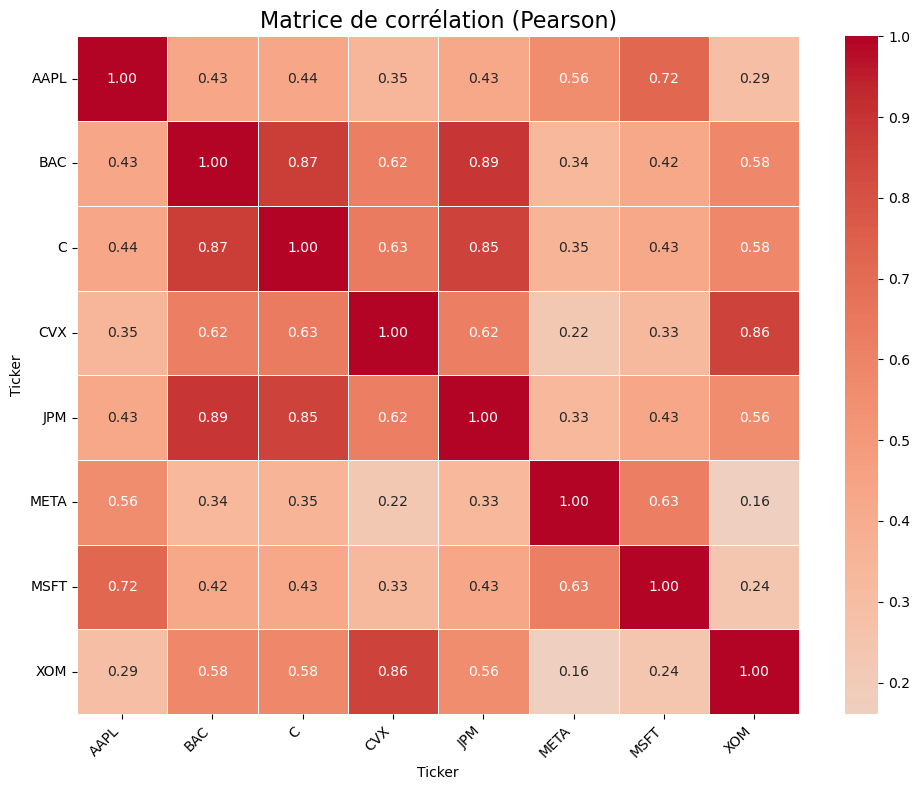

In [5]:
import seaborn as sns

# --- Cr√©ation de la heatmap  ---
plt.figure(figsize=(10, 8)) # Ajuster la taille pour une meilleure lisibilit√©

sns.heatmap(
    corr_pearson, 
    annot=True,          # Afficher les valeurs de corr√©lation sur la carte
    cmap='coolwarm',     # Utiliser une palette de couleurs "chaud/froid" adapt√©e aux corr√©lations
    fmt=".2f",           # Formater les nombres avec 2 d√©cimales
    linewidths=.5,       # Ajouter de fines lignes entre les cellules
    center=0             # Centrer la palette de couleurs sur la valeur 0
)

plt.title("Matrice de corr√©lation (Pearson)", fontsize=16)
plt.xticks(rotation=45, ha="right") # Am√©liorer la lisibilit√© des √©tiquettes
plt.yticks(rotation=0)
plt.tight_layout() # Ajuster automatiquement les marges
plt.show()

## 2) Corr√©lations robustes (Spearman, Kendall) ‚Äî Matrice & Heatmap

Les corr√©lations **non param√©triques** de **Spearman** et **Kendall** √©valuent la **d√©pendance monotone** entre deux s√©ries (ex. rendements), sans exiger de lin√©arit√© ni de normalit√©.  
Elles sont **moins sensibles aux valeurs extr√™mes** que Pearson, donc mieux adapt√©es √† des donn√©es financi√®res **asym√©triques** et **√† queues √©paisses**.  



### D√©finition
- **Spearman (œÅ‚Çõ)** : corr√©lation de Pearson **appliqu√©e aux rangs** des observations.  
  On remplace chaque valeur par son rang, puis on calcule Pearson sur ces rangs.  
- **Kendall (œÑ·µ¶)** : bas√©e sur les **paires concordantes/discordantes** ;  
  œÑ = P(concordance) ‚àí P(discordance), avec **œÑ·µ¶** qui corrige les ex aequo.  
- Les coefficients varient de **‚àí1 √† +1** (m√™me lecture g√©n√©rale que Pearson).  
  **|œÑ·µ¶| est souvent plus faible que |œÅ‚Çõ|** pour un m√™me signal ‚Äî c‚Äôest normal.  



### Conditions d‚Äôutilisation
- Variables **ordinales ou continues** (rendements) **align√©es** sur les m√™mes dates.  
- Relation attendue **monotone** (croissante ou d√©croissante), pas forc√©ment lin√©aire.  
- Mesures **robustes aux outliers** ; pr√©voir un **nettoyage/winsorisation l√©g√®re** si n√©cessaire.  
- Si beaucoup d‚Äô**ex aequo**, privil√©gier **Kendall œÑ·µ¶**.  



### Limites
- Ne captent pas les **relations non monotones** (ex. en U).  
- **Kendall** est **plus co√ªteuse** √† calculer sur de grands univers d‚Äôactifs.  
- Les amplitudes sont **moins ‚Äúspectaculaires‚Äù** que Pearson : comparez **m√©thodes entre elles**, pas les valeurs brutes.  


### Interpr√©tation en finance
- **Spearman/Kendall √©lev√©es** ‚Üí actifs √©voluant **monotoniquement ensemble** ‚Üí diversification r√©duite.  
- **Proches de 0** ‚Üí d√©pendance faible/instable ‚Üí diversification potentiellement meilleure.  
- En **march√©s stress√©s**, ces mesures restent souvent **plus stables** que Pearson face aux chocs extr√™mes.  
- La **heatmap** met en √©vidence des **blocs** (secteurs, devises, maturit√©s) utiles pour la construction de portefeuille.  


üëâ **En r√©sum√©**  
- Utilisez **Spearman** comme alternative robuste par d√©faut.  
- Ajoutez **Kendall œÑ·µ¶** en cas de nombreux **ex aequo** ou de petit √©chantillon.  
- Comparez la matrice robuste √† **Pearson**, suivez la **stabilit√© temporelle** (fen√™tres roulantes) et **masquez les corr√©lations non significatives**.  


In [8]:

corr_spearman = asset_r.corr(method="spearman")
corr_kendall = asset_r.corr(method="kendall")
display(corr_spearman.round(3))
display(corr_kendall.round(3))


Ticker   AAPL    BAC      C    CVX    JPM   META   MSFT    XOM
Ticker                                                        
AAPL    1.000  0.299  0.308  0.202  0.315  0.531  0.667  0.184
BAC     0.299  1.000  0.835  0.499  0.850  0.298  0.279  0.490
C       0.308  0.835  1.000  0.486  0.805  0.316  0.307  0.478
CVX     0.202  0.499  0.486  1.000  0.481  0.126  0.145  0.872
JPM     0.315  0.850  0.805  0.481  1.000  0.300  0.305  0.461
META    0.531  0.298  0.316  0.126  0.300  1.000  0.638  0.105
MSFT    0.667  0.279  0.307  0.145  0.305  0.638  1.000  0.096
XOM     0.184  0.490  0.478  0.872  0.461  0.105  0.096  1.000

Ticker   AAPL    BAC      C    CVX    JPM   META   MSFT    XOM
Ticker                                                        
AAPL    1.000  0.208  0.215  0.139  0.222  0.381  0.494  0.126
BAC     0.208  1.000  0.656  0.354  0.674  0.206  0.193  0.347
C       0.215  0.656  1.000  0.344  0.625  0.218  0.214  0.339
CVX     0.139  0.354  0.344  1.000  0.343  0.086  0.099  0.701
JPM     0.222  0.674  0.625  0.343  1.000  0.207  0.214  0.327
META    0.381  0.206  0.218  0.086  0.207  1.000  0.470  0.071
MSFT    0.494  0.193  0.214  0.099  0.214  0.470  1.000  0.064
XOM     0.126  0.347  0.339  0.701  0.327  0.071  0.064  1.000

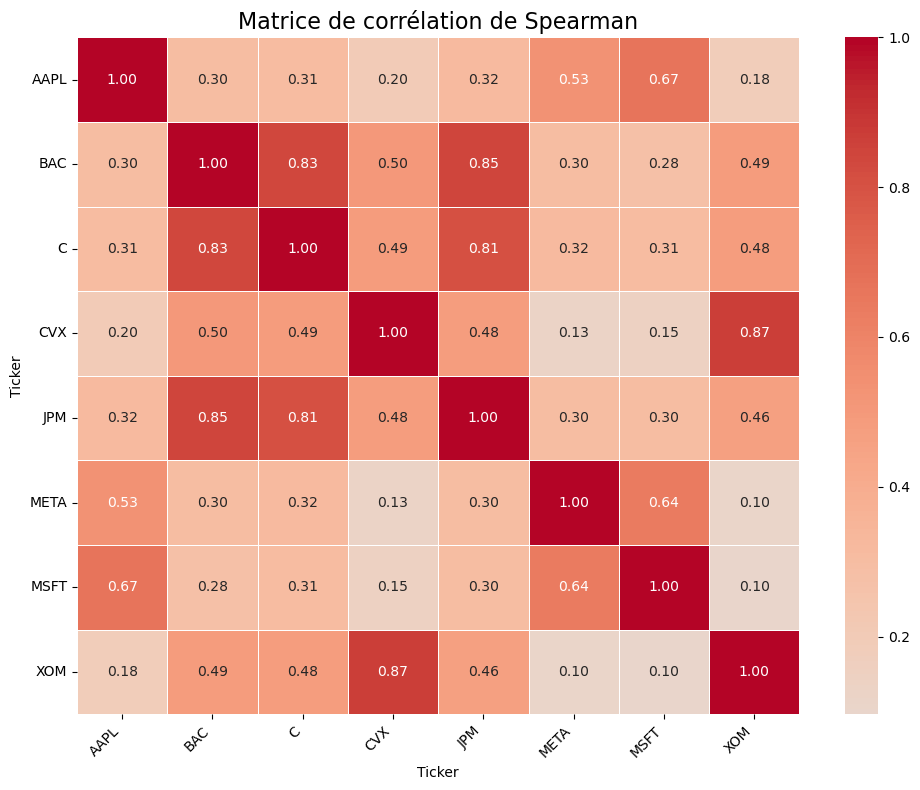

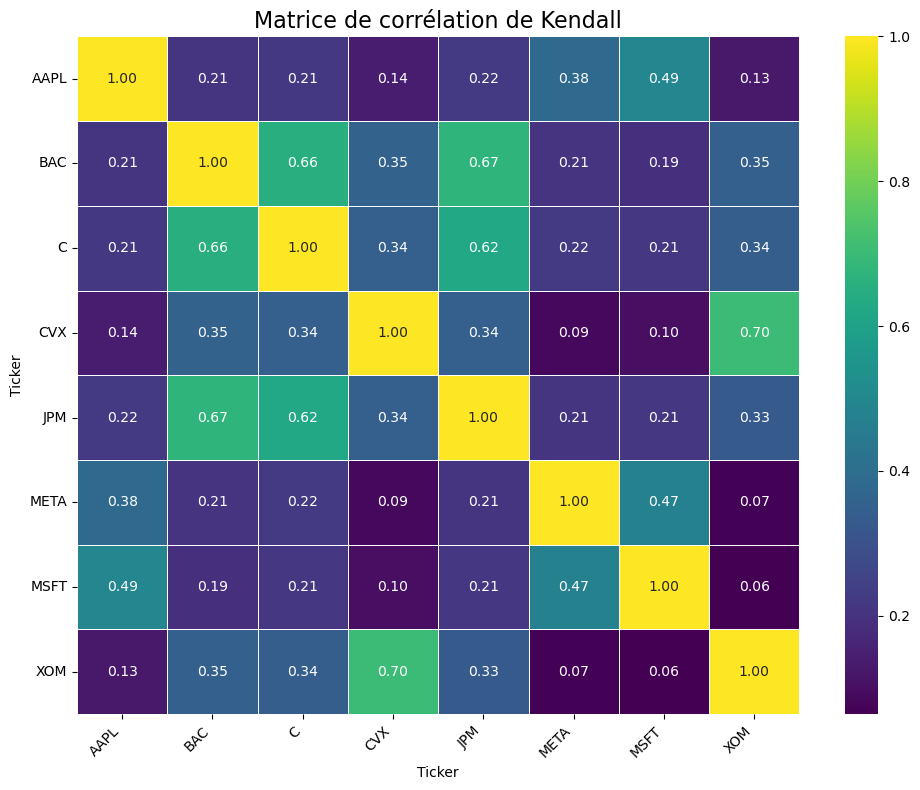

In [9]:
# ===============================================
# Heatmap pour la corr√©lation de Spearman
# ===============================================
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_spearman,
    annot=True,          # Afficher les valeurs
    cmap='coolwarm',     # Palette de couleurs bleu/rouge
    fmt=".2f",           # Formatage √† 2 d√©cimales
    linewidths=.5,
    center=0
)
plt.title("Matrice de corr√©lation de Spearman", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ===============================================
# 2. Heatmap pour la corr√©lation de Kendall
# ===============================================
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_kendall,
    annot=True,
    cmap='viridis',      # On peut varier la palette pour les distinguer
    fmt=".2f",
    linewidths=.5
)
plt.title("Matrice de corr√©lation de Kendall", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## 3) R√©gression simple CAPM (express)

Le CAPM(Capital Asset Pricing Model)  relie le rendement d‚Äôun actif au facteur de march√© pour estimer deux param√®tres cl√©s :
- **B√™ta (Œ≤)** : sensibilit√© de l‚Äôactif aux mouvements du march√© (risque syst√©matique).
- **Alpha (Œ±)** : surperformance ajust√©e du risque, non expliqu√©e par le march√©.




### √âtapes d‚Äôestimation 
1. Effectuer une **r√©gression lin√©aire** des rendements en exc√®s de l‚Äôactif sur ceux du march√© en incluant une constante.
2. Relever **alpha**, **b√™ta**, les **statistiques t**, les **p-values** et le **R¬≤**.
3. V√©rifier les **r√©sidus** (autocorr√©lation, h√©t√©rosc√©dasticit√©) et, si besoin, utiliser des **erreurs robustes**.
4. **Annualiser** alpha si n√©cessaire (ex. donn√©es mensuelles) en utilisant une approximation simple ou une composition sur la p√©riode.
5. Visualiser un **nuage de points** ‚Äúmarch√© en exc√®s‚Äù vs ‚Äúactif en exc√®s‚Äù et la **droite d‚Äôajustement**.



### Interpr√©tation 
- **B√™ta > 1** : actif plus sensible que le march√© ; **b√™ta < 1** : moins sensible ; **b√™ta n√©gatif** : √©volution inverse au march√©.
- **Alpha positif et significatif** : surperformance non expliqu√©e par le march√© (√† challenger).
- **R¬≤ √©lev√©** : part importante de la variance expliqu√©e par le facteur march√©.




### Limites
- Mod√®le **monofacteur** : ne capture pas toutes les sources de risque/rendement.
- **Ruptures de r√©gime** possibles (param√®tres non stables).
- Sensibilit√© au **choix du proxy de march√©** et du **taux sans risque**.






In [11]:

TARGET = "META"
y = asset_r[TARGET].dropna()
x = market_r.loc[y.index]

res = stats.linregress(x, y)
alpha, beta, r2 = res.intercept, res.slope, res.rvalue**2

summary = pd.DataFrame({
    "alpha":[alpha], "beta":[beta], "R2":[r2], "p_value_beta":[res.pvalue]
}, index=[TARGET])
display(summary.round(4))


alpha    beta      R2  p_value_beta
META  0.0005  1.3249  0.4043           0.0

## 4) Tableau de contingence & test Chi-deux

Le **tableau de contingence** croise deux variables **cat√©gorielles** (ou des variables continues **discr√©tis√©es**) pour r√©sumer leurs effectifs communs.  
Le **test du Chi-deux d‚Äôind√©pendance** v√©rifie si la **r√©partition** observ√©e dans le tableau est compatible avec l‚Äô**ind√©pendance** entre les deux variables.

### Hypoth√®ses
- **H0 (ind√©pendance)** : la distribution de la variable A ne d√©pend pas des modalit√©s de B.  
- **H1 (association)** : il existe une d√©pendance entre A et B.


### Taille d‚Äôeffet 
- **V de Cram√©r** (0 ‚Üí 1) : force de l‚Äôassociation (interpr√©tation courante)  
  - ‚âà 0,10 : faible | ‚âà 0,30 : moyenne | ‚âà 0,50 : forte (rep√®res usuels)  

### Interpr√©tation type (exemple de trame)
- Le test indique **p-value < 0,05** : **association** entre la tranche de PD et le d√©faut.  
- **V de Cram√©r ‚âà 0,28** : association **de force moyenne**.  


In [16]:

# Variables binaires : march√© en hausse / actif en hausse
# Existe-t-il une relation statistiquement significative entre la direction du march√© (hausse/baisse) et la direction d'un actif sp√©cifique ? 
mr = (market_r > 0).astype(int).rename("MarketUp")
ar = (asset_r[TARGET] > 0).astype(int).rename("AssetUp")
df_cat = pd.concat([mr, ar], axis=1).dropna()

df_cat


MarketUp  AssetUp
Date                         
2020-01-03         0        0
2020-01-06         1        1
2020-01-07         0        1
2020-01-08         1        1
2020-01-09         1        1
...              ...      ...
2025-09-15         1        1
2025-09-16         0        1
2025-09-17         0        0
2025-09-18         1        1
2025-09-19         1        0

[1436 rows x 2 columns]

In [17]:

# Tableau de contingence
cont = pd.crosstab(df_cat["MarketUp"], df_cat["AssetUp"])
display(cont)


AssetUp     0    1
MarketUp          
0         473  186
1         214  563

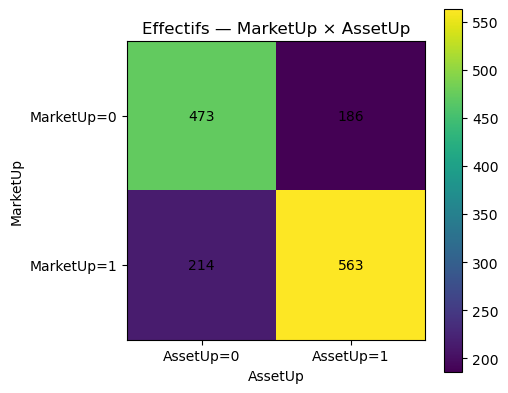

In [18]:


# === VISUELS ===
import matplotlib.pyplot as plt

# 1) Heatmap des effectifs observ√©s (2x2)
fig, ax = plt.subplots(figsize=(5.2, 4.4))
im = ax.imshow(cont.values, aspect='equal')
ax.set_xticks(np.arange(cont.shape[1]))
ax.set_yticks(np.arange(cont.shape[0]))
ax.set_xticklabels([f"AssetUp={col}" for col in cont.columns])
ax.set_yticklabels([f"MarketUp={idx}" for idx in cont.index])
# Annoter les effectifs
for i in range(cont.shape[0]):
    for j in range(cont.shape[1]):
        ax.text(j, i, int(cont.values[i, j]), ha='center', va='center')
ax.set_title("Effectifs ‚Äî MarketUp √ó AssetUp")
ax.set_xlabel("AssetUp")
ax.set_ylabel("MarketUp")
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()




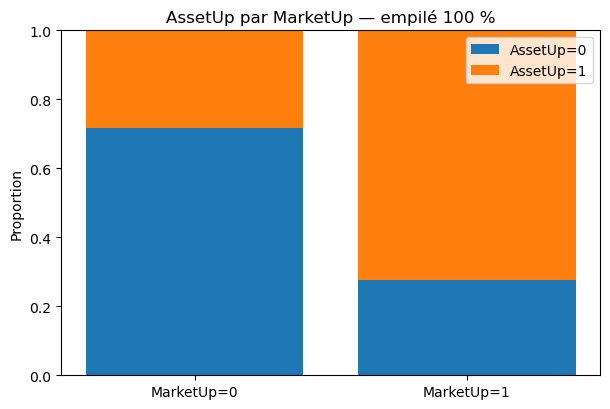

In [19]:


# === VISUELS ===


# 2) Barres empil√©es 100 % (AssetUp conditionnel √† MarketUp)
prop = cont.div(cont.sum(axis=1), axis=0)  # proportions par ligne
fig, ax = plt.subplots(figsize=(6.2, 4.2))
bottom = np.zeros(len(prop))
x = np.arange(len(prop.index))

for j, col in enumerate(prop.columns):
    ax.bar(x, prop[col].values, bottom=bottom, label=f"AssetUp={col}")
    bottom += prop[col].values

ax.set_xticks(x)
ax.set_xticklabels([f"MarketUp={i}" for i in prop.index])
ax.set_ylim(0, 1)
ax.set_ylabel("Proportion")
ax.set_title("AssetUp par MarketUp ‚Äî empil√© 100 %")
ax.legend()
plt.tight_layout()
plt.show()




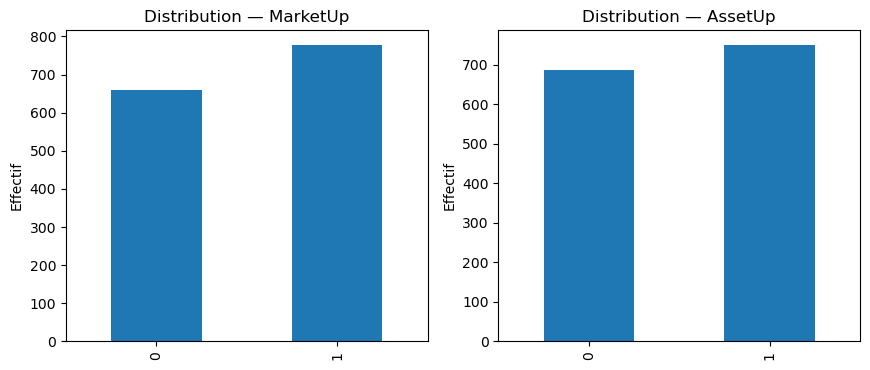

In [20]:

# 3) Marges : distributions s√©par√©es de MarketUp et AssetUp
fig, axes = plt.subplots(1, 2, figsize=(8.8, 3.8))

# Distribution MarketUp (somme sur colonnes)
cont.sum(axis=1).plot(kind='bar', ax=axes[0])
axes[0].set_title("Distribution ‚Äî MarketUp")
axes[0].set_xlabel("")
axes[0].set_ylabel("Effectif")

# Distribution AssetUp (somme sur lignes)
cont.sum(axis=0).plot(kind='bar', ax=axes[1])
axes[1].set_title("Distribution ‚Äî AssetUp")
axes[1].set_xlabel("")
axes[1].set_ylabel("Effectif")

plt.tight_layout()
plt.show()



In [21]:

# Test du Chi-deux
from scipy import stats
import numpy as np

chi2, p, dof, exp = stats.chi2_contingency(cont)

# V de Cram√©r
n = cont.to_numpy().sum()
r, c = cont.shape
min_dim = max(1, min(r - 1, c - 1))  # s√©curit√© si dimension minimale = 0
v_cramer = np.sqrt(chi2 / (n * min_dim))

print(f"Chi2={chi2:.3f}, ddl={dof}, p-value={p:.4f}, V de Cram√©r={v_cramer:.3f}")

Chi2=277.823, ddl=1, p-value=0.0000, V de Cram√©r=0.440


## 5) Comparer deux groupes

**Objectif.** Comparer les rendements de deux groupes **ind√©pendants** :
- **Tech** : META, AAPL, MSFT  
- **Finance** : JPM, BAC, C  

### Proc√©dure
1. **Boxplot bivari√©** d‚Äôouverture (Tech vs Finance) pour visualiser m√©diane, dispersion et outliers.  
2. **Tests d‚Äôhypoth√®ses** :
   - **Student** (var. √©gales) : statistique t, p-value.  
   - **Welch** (var. in√©gales) : statistique t, p-value, **df de Welch**.  
   - **Mann‚ÄìWhitney** (Wilcoxon rang-sum) : U et p-value (bilat√©ral).  

### Crit√®res de d√©cision & lecture
- **Seuil** usuel : Œ± = 0,05 (adapter selon le contexte).  
- **Welch** est **la r√©f√©rence** si les variances ne sont pas √©gales (ou si le doute persiste).  
- **Student** est rapport√© **√† titre informatif** si normalit√© + variances ‚âà √©gales.  
- **Mann‚ÄìWhitney** est **robuste** si non-normalit√©/outliers : lire **direction** et **amplitude** avec **Cliff‚Äôs delta**.  




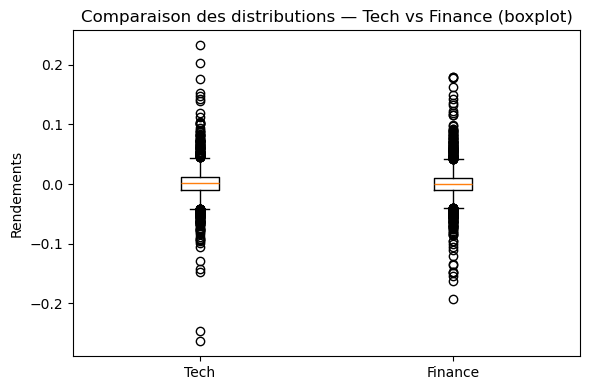

In [23]:
# On commence par un boxplot bivari√© (Tech vs Finance).

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd # Import pandas for DataFrame

# Groupes (exemple)
group_tech = ["META","AAPL","MSFT"]
group_fin  = ["JPM","BAC","C"]





tech = asset_r[group_tech].stack().dropna()
fin  = asset_r[group_fin].stack().dropna()

# ---------- 1) Boxplot bivari√© ----------
plt.figure(figsize=(6,4))
plt.boxplot([tech.values, fin.values], tick_labels=["Tech", "Finance"], showfliers=True) # Changed labels to tick_labels
plt.ylabel("Rendements")
plt.title("Comparaison des distributions ‚Äî Tech vs Finance (boxplot)")
plt.tight_layout()
plt.show()

In [26]:
from scipy import stats
import numpy as np # Assurez-vous que numpy est import√©

# === Comparer deux groupes : Student, Welch et Wilcoxon (rank-sum) ===

# ---------- 1) Calcul des statistiques descriptives ----------

n1, n2 = tech.size, fin.size
m1, m2 = tech.mean(), fin.mean() # LIGNES AJOUT√âES
s1, s2 = tech.std(ddof=1), fin.std(ddof=1)

# ---------- 2) Tests param√©triques ----------
# Student (variances √©gales)
t_student, p_student = stats.ttest_ind(tech, fin, equal_var=True, nan_policy="omit")

# Welch (variances in√©gales)
t_welch, p_welch = stats.ttest_ind(tech, fin, equal_var=False, nan_policy="omit")

# Degr√©s de libert√© de Welch (info utile)
df_welch = (s1**2/n1 + s2**2/n2)**2 / ((s1**2/n1)**2/(n1-1) + (s2**2/n2)**2/(n2-1))

# ---------- 3) Test non param√©trique ----------
# Wilcoxon "rank-sum" pour groupes ind√©pendants = Mann‚ÄìWhitney U (bilat√©ral)
u_stat, p_mw = stats.mannwhitneyu(tech, fin, alternative="two-sided")


# ---------- 4) R√©sum√© ----------
print("----- R√©sum√© comparatif Tech vs Finance -----")
print(f"N_tech={n1}, N_fin={n2}")
print(f"Moyenne Tech={m1:.6f} | Moyenne Finance={m2:.6f}")
print(f"Std Dev Tech={s1:.6f} | Std Dev Finance={s2:.6f}")

print("\n--- Tests de diff√©rence de moyennes ---")
print(f"Student t-test: t={t_student:.3f}, p={p_student:.5f}")
print(f"Welch t-test:   t={t_welch:.3f}, p={p_welch:.5f} (df={df_welch:.1f})")
print(f"Mann‚ÄìWhitney U: U={u_stat:.3f}, p={p_mw:.5f}")

----- R√©sum√© comparatif Tech vs Finance -----
N_tech=4308, N_fin=4308
Moyenne Tech=0.001132 | Moyenne Finance=0.000695
Std Dev Tech=0.022731 | Std Dev Finance=0.022180

--- Tests de diff√©rence de moyennes ---
Student t-test: t=0.902, p=0.36685
Welch t-test:   t=0.902, p=0.36685 (df=8608.8)
Mann‚ÄìWhitney U: U=9445593.000, p=0.15005


## 6) Comparer plusieurs groupes (ANOVA + Kruskal)

**Objectif.** Tester si les **moyennes** (ou distributions) de **plus de deux groupes** diff√®rent de mani√®re significative  
(ex. secteurs : Tech, Finance, √ânergie ; ou tranches de PD ; ou r√©gimes de march√©).


### Quand utiliser quoi ?
- **ANOVA √† 1 facteur (classique)** : donn√©es **num√©riques continues**, groupes **ind√©pendants**,  
  **normalit√©** raisonnable **dans chaque groupe** et **homog√©n√©it√© des variances** (‚âà Levene OK).
- **Welch ANOVA / Brown‚ÄìForsythe** : normalit√© OK mais **variances in√©gales** et/ou tailles diff√©rentes.
- **Kruskal‚ÄìWallis (non param√©trique)** : **non-normalit√©**, **outliers lourds**, donn√©es **ordinales**.
.



### Hypoth√®ses
- **H0** : toutes les moyennes (ANOVA) ou distributions (Kruskal) sont **√©gales** entre groupes.  
- **H1** : au moins un groupe **diff√®re** des autres.  
- Observations **ind√©pendantes** entre groupes.



### Pr√©paration des donn√©es
1. D√©finir les **groupes** (√©tiquettes claires, ‚â• 2 niveaux ; id√©alement ‚â• 3).  
2. **Nettoyer** : outliers extr√™mes (winsorisation l√©g√®re si besoin), valeurs manquantes.  
3. **V√©rifier** : normalit√© par groupe (QQ-plot, Shapiro) et **√©galit√© des variances** (Levene).  
4. Garder des **tailles raisonnables** par groupe (√©viter les groupes trop petits).



### Proc√©dure 
1. **Visualiser en premier** : **boxplots** multi-groupes (ordre par m√©diane), √©ventuellement **violins** ou **densit√©s**.  
2. **Test global** :  
   - ANOVA (classique) si normalit√© + variances ‚âà √©gales.  
   - **Welch ANOVA** si variances in√©gales.  
   - **Kruskal‚ÄìWallis** si non-normalit√©/ordinal/outliers.  


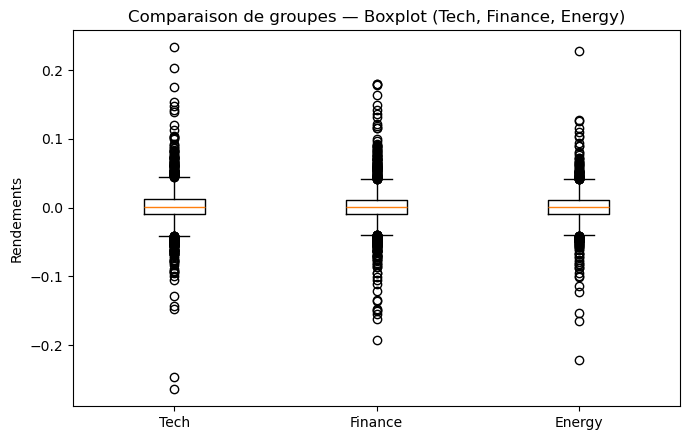

In [29]:
# === Boxplot + tests : ANOVA, Kruskal‚ÄìWallis, normalit√© (Shapiro) et Levene ===

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# 1) Groupes
group_tech   = ["META", "AAPL", "MSFT"]
group_fin    = ["JPM", "BAC", "C"]
group_energy = ["XOM", "CVX"]


tech   = asset_r[group_tech].stack().dropna().values
fin    = asset_r[group_fin].stack().dropna().values
energy = asset_r[group_energy].stack().dropna().values

groups = [tech, fin, energy]
labels = ["Tech", "Finance", "Energy"]
alpha  = 0.05

# 2) Boxplot multigroupes
plt.figure(figsize=(7, 4.5))
plt.boxplot(groups, tick_labels=labels, showfliers=True) # Changed labels to tick_labels
plt.ylabel("Rendements")
plt.title("Comparaison de groupes ‚Äî Boxplot (Tech, Finance, Energy)")
plt.tight_layout()
plt.show()


In [30]:

# 3) Normalit√© par groupe (Shapiro‚ÄìWilk)
for lab, g in zip(labels, groups):
    W, p = stats.shapiro(g)
    print(f"Normalit√© (Shapiro) {lab}: W={W:.3f}, p={p:.5f} ‚Üí {'OK' if p>alpha else 'NON'}")

# 4) √âgalit√© des variances (Levene, robuste)
W_lev, p_lev = stats.levene(*groups, center='median')
print(f"Levene (variances √©gales ?) : W={W_lev:.3f}, p={p_lev:.5f} ‚Üí {'OK' if p_lev>alpha else 'NON'}")


Normalit√© (Shapiro) Tech: W=0.889, p=0.00000 ‚Üí NON
Normalit√© (Shapiro) Finance: W=0.881, p=0.00000 ‚Üí NON
Normalit√© (Shapiro) Energy: W=0.901, p=0.00000 ‚Üí NON
Levene (variances √©gales ?) : W=1.874, p=0.15350 ‚Üí OK


In [32]:

# 5) Tests globaux
# ANOVA (classique, suppose normalit√© + variances ‚âà √©gales)
F, pA = stats.f_oneway(*groups)
print(f"ANOVA un facteur : F={F:.3f}, p={pA:.5f}")

# Kruskal‚ÄìWallis (non param√©trique, rangs)
H, pK = stats.kruskal(*groups)
print(f"Kruskal‚ÄìWallis : H={H:.3f}, p={pK:.5f}")

ANOVA un facteur : F=0.554, p=0.57480
Kruskal‚ÄìWallis : H=2.169, p=0.33805
